<a href="https://colab.research.google.com/github/super-818/state-ins/blob/main/STATE_for_Virtual_Cell_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STATE for Virtual Cell Challenge

This notebook walks through how to train a STATE model for context generalization in the Arc [Virtual Cell Challenge](https://virtualcellchallenge.org/).

While STATE was not designed specifically for this setting (1. transcriptome-wide effect prediction and 2. predicting effects of perturbations unseen in any context in the test dataset), we present here an adapted version based on the model introduced in the paper. In particular, we simplify the basal encoder to a linear layer and shift the residual connection to the final expression prediction space. For more details on STATE, please refer to the [preprint](https://www.biorxiv.org/content/10.1101/2025.06.26.661135).

If you use STATE to participate in the Virtual Cell Competition, we ask that you mention it in your model description (and if you are a finalist you'll be required to share this information).

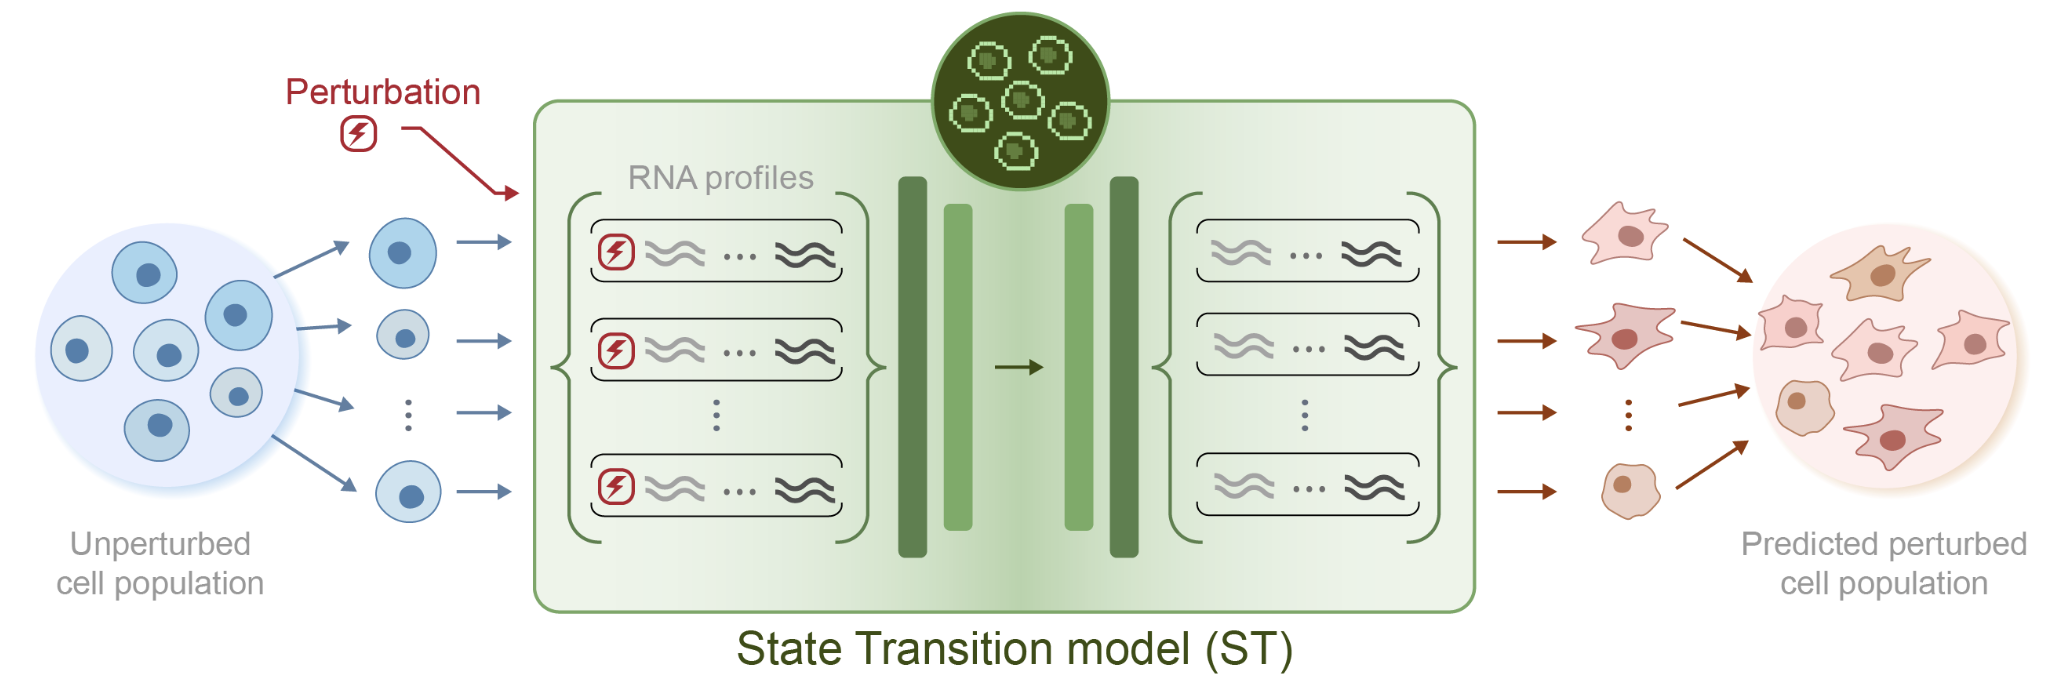

# Clone the repository.

In [ ]:
# Clone the repository
! git clone https://github.com/ArcInstitute/state.git
%cd state

# Colab-specific config for pytorch lightning
import os
os.environ['MPLBACKEND'] = 'Agg'

Cloning into 'state'...
remote: Enumerating objects: 6342, done.
remote: Counting objects: 100% (502/502), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 6342 (delta 365), reused 343 (delta 276), pack-reused 5840 (from 2)
Receiving objects: 100% (6342/6342), 122.68 MiB | 14.96 MiB/s, done.
Resolving deltas: 100% (3864/3864), done.
/content/state


# Training Data Setup

The training and validation data provided for the Virtual Cell Challenge is from H1 cells. STATE is meant for context generalization, not perturbation generalization, so we need a separate dataset to jointly train on to learn perturbation embeddings. In our case, we jointly train on the [Replogle genome wide and essential screens](https://plus.figshare.com/articles/dataset/_Mapping_information-rich_genotype-phenotype_landscapes_with_genome-scale_Perturb-seq_Replogle_et_al_2022_processed_Perturb-seq_datasets/20029387). We have already filtered the data to only include the 200 perturbations that appear in the competition train / val set.

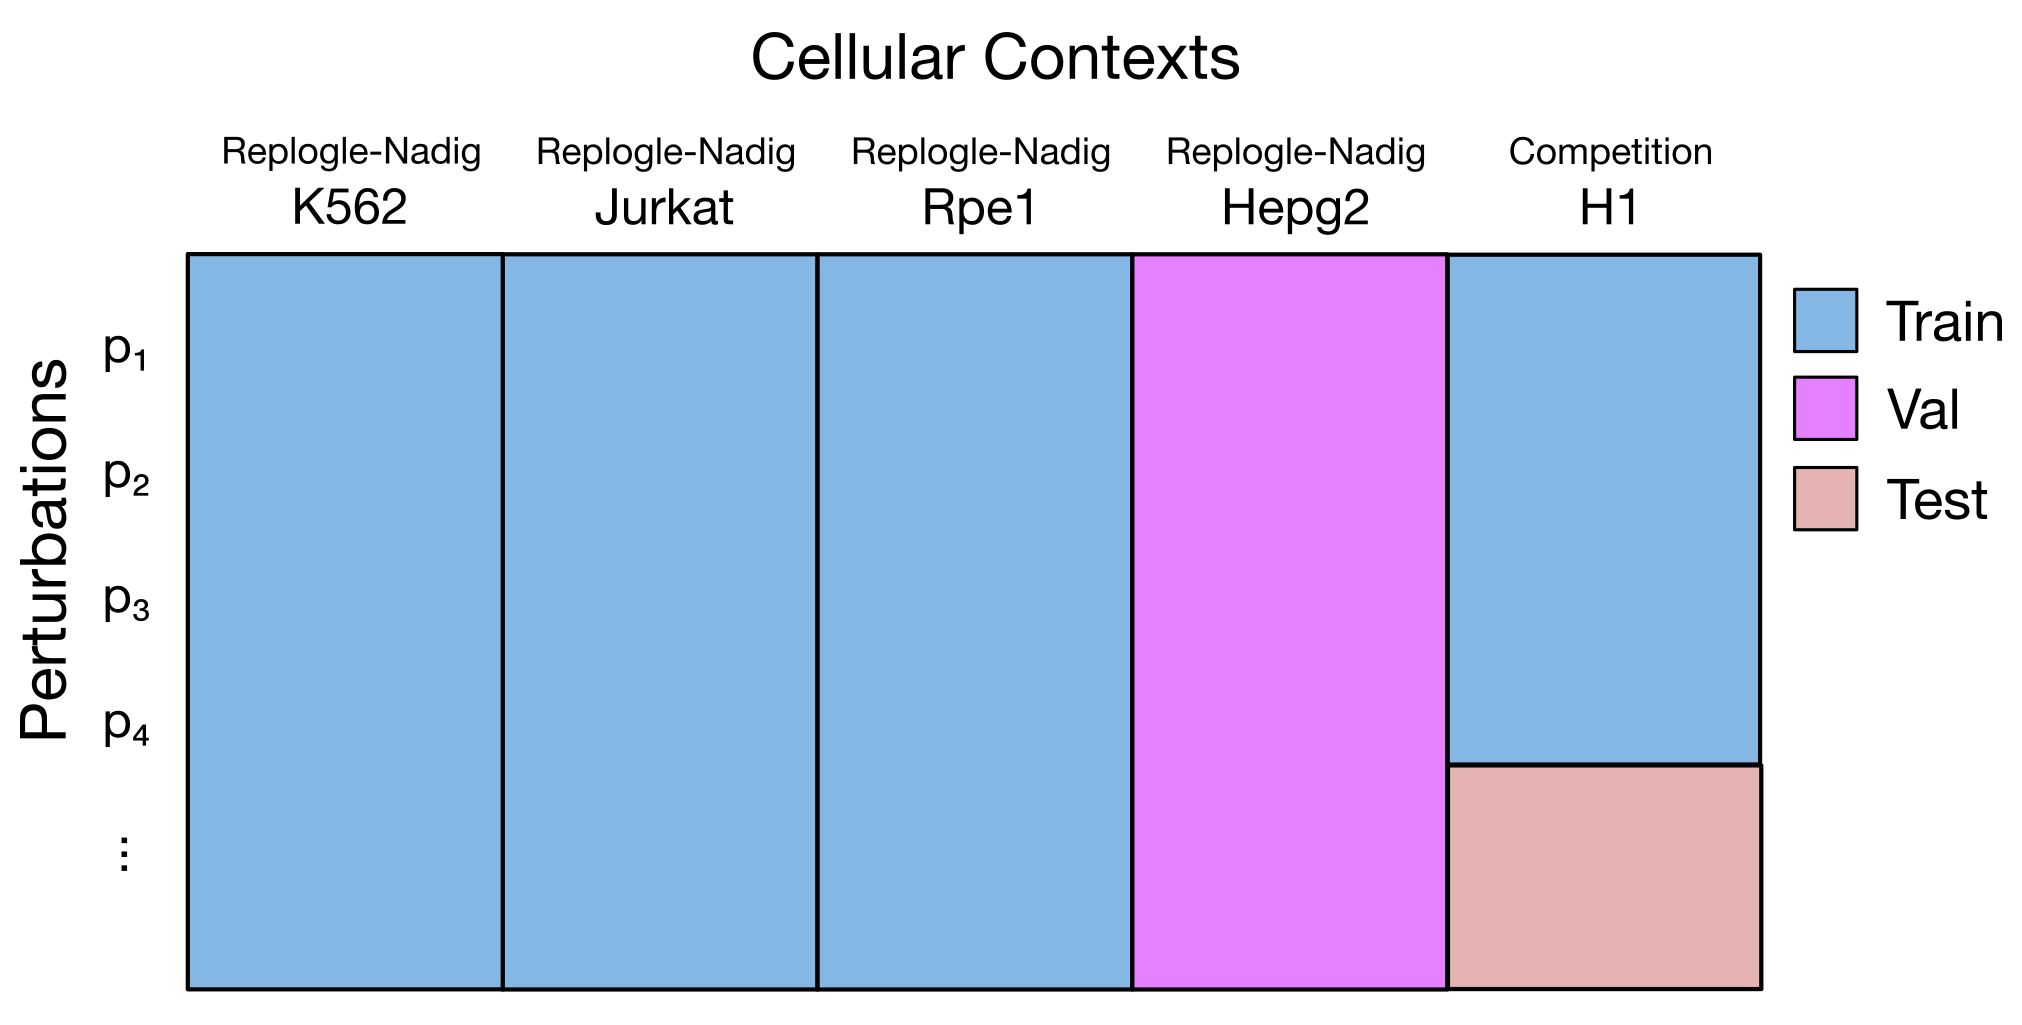

Users are encouraged to experiment with other datasets for model training!

# Download the Replogle-Nadig training dataset.

In [ ]:
%pip install requests tqdm

import requests
from tqdm.auto import tqdm  # picks the best bar for the environment

url = "https://storage.googleapis.com/vcc_data_prod/datasets/state/competition_support_set.zip"
output_path = "competition_support_set.zip"

# stream the download so we can track progress
response = requests.get(url, stream=True)
total = int(response.headers.get("content-length", 0))

with open(output_path, "wb") as f, tqdm(
    total=total, unit='B', unit_scale=True, desc="Downloading"
) as bar:
    for chunk in response.iter_content(chunk_size=8192):
        if not chunk:
            break
        f.write(chunk)
        bar.update(len(chunk))

Downloading:   0%|          | 0.00/6.69G [00:00<?, ?B/s]

In [ ]:
from zipfile import ZipFile
from tqdm.auto import tqdm
import os

out_dir  = "competition_support_set"

os.makedirs(out_dir, exist_ok=True)

with ZipFile(output_path, 'r') as z:
    for member in tqdm(z.infolist(), desc="Unzipping", unit="file"):
        z.extract(member, out_dir)

Unzipping:   0%|          | 0/10 [00:00<?, ?file/s]

In [ ]:
# @title Set Weights and Biases Entity for tracking
entity = "arcinstitute" # @param {"type":"string","placeholder":"arcinstitute"}
! sed -i 's|entity: your_entity_name|entity: ${entity}|g' src/state/configs/wandb/default.yaml

# Installation and Training

In [ ]:
# install the package
! uv run state --help

Streaming output truncated to the last 5000 lines.
nvidia-cusparselt-cu12 ------------------------------ 23.46 MiB/149.52 MiB
nvidia-cusolver-cu12 ------------------------------ 23.62 MiB/150.90 MiB
nvidia-cufft-cu12 ------------------------------ 23.59 MiB/190.95 MiB
nvidia-nccl-cu12 ------------------------------ 23.29 MiB/191.99 MiB
nvidia-cusparse-cu12 ------------------------------ 23.42 MiB/206.53 MiB
nvidia-cublas-cu12 ------------------------------ 23.48 MiB/374.93 MiB
nvidia-cudnn-cu12 ------------------------------ 23.29 MiB/544.54 MiB
⠸ Preparing packages... (107/122)
wandb      ------------------------------ 20.84 MiB/21.21 MiB
polars     ------------------------------ 23.96 MiB/33.43 MiB
scipy      ------------------------------ 19.19 MiB/35.91 MiB
pyarrow    ------------------------------ 24.14 MiB/40.34 MiB
llvmlite   ------------------------------ 23.83 MiB/40.40 MiB
nvidia-curand-cu12 ------------------------------ 23.81 MiB/53.67 MiB
triton     -----------------------

In [ ]:
# State TX Training Command
# This setups up training for State across datasets, using ESM2 featurizations
# of genes as the perturbation embeddings. Note that we are now generalizing
# across both contexts and perturbations (not just contexts)

! uv run state tx train \
  data.kwargs.toml_config_path="competition_support_set/starter.toml" \
  data.kwargs.num_workers=4 \
  data.kwargs.batch_col="batch_var" \
  data.kwargs.pert_col="target_gene" \
  data.kwargs.cell_type_key="cell_type" \
  data.kwargs.control_pert="non-targeting" \
  data.kwargs.perturbation_features_file="competition_support_set/ESM2_pert_features.pt" \
  training.max_steps=40000 \
  training.ckpt_every_n_steps=2000 \
  model=state_sm \
  wandb.tags="[first_run]" \
  output_dir="competition" \
  name="first_run"

Seed set to 42
/content/state/competition_support_set/{competition_train,k562_gwps,rpe1,jurkat,k562,hepg2}.h5
Dataset path does not exist: /content/state/competition_support_set/{competition_train,k562_gwps,rpe1,jurkat,k562,hepg2}.h5
Processed competition_train: 221273 train, 0 val, 0 test
Processing replogle_h1:  17% 1/6 [00:00<00:01,  4.24it/s]No cell barcode information found in /content/state/competition_support_set/k562_gwps.h5. Generating generic barcodes.
Processed k562_gwps: 111605 train, 0 val, 0 test
Processing replogle_h1:  17% 1/6 [00:00<00:01,  4.24it/s]No cell barcode information found in /content/state/competition_support_set/rpe1.h5. Generating generic barcodes.
Processed rpe1: 22317 train, 0 val, 0 test
Processing replogle_h1:  50% 3/6 [00:00<00:00,  9.92it/s]No cell barcode information found in /content/state/competition_support_set/jurkat.h5. Generating generic barcodes.
Processed jurkat: 21412 train, 0 val, 0 test
Processing replogle_h1:  50% 3/6 [00:00<00:00,  9.92

# Run inference on the competition validation perturbations.

In [ ]:
# View the available checkpoints
# This will be populated as you run training

! ls competition/first_run/checkpoints/

 final.ckpt  'step=200.ckpt'  'step=400.ckpt'


In [ ]:
# Run inference on validation anndata - make sure the checkpoint exists
! uv run state tx infer \
  --output "competition/prediction.h5ad" \
  --model_dir "competition/first_run" \
  --checkpoint "competition/first_run/checkpoints/final.ckpt" \
  --adata "competition_support_set/competition_val_template.h5ad" \
  --pert_col "target_gene"

INFO:state._cli._tx._infer:Loaded config from competition/first_run/config.yaml
INFO:state._cli._tx._infer:Loading model from checkpoint: competition/first_run/checkpoints/final.ckpt
PertSetsPerturbationModel(
  (loss_fn): SamplesLoss()
  (pert_encoder): Sequential(
    (0): Linear(in_features=5120, out_features=672, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=672, out_features=672, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=672, out_features=672, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=672, out_features=672, bias=True)
  )
  (basal_encoder): Linear(in_features=18080, out_features=672, bias=True)
  (transformer_backbone): LlamaBidirectionalModel(
    (embed_tokens): Embedding(32000, 672, padding_idx=0)
    (layers): ModuleList(
      (0-3): 4 x LlamaDecoderLayer(
        (self_att

# Run Cell-Eval on the resulting anndata and submit your entry to the leaderboard.

In [ ]:
# install zstd for cell eval prep
! sudo apt install -y zstd

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  zstd
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 603 kB of archives.
After this operation, 1,695 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 zstd amd64 1.4.8+dfsg-3build1 [603 kB]
Fetched 603 kB in 2s (346 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package zstd.
(Reading database ... 126281 files and directories currently i

In [ ]:
! uv tool run --from git+https://github.com/ArcInstitute/cell-eval@main cell-eval prep -i competition/prediction.h5ad -g competition_support_set/gene_names.csv

   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
   Updating https://github.com/ArcInstitute/cell-eval (main)
    Updated https://github.com/ArcInstitute/cell-eval (162997c1bd0e6b52e7abac6a9b493
   Building cell-eval @ git+https://github.com/ArcInstitute/cell-eval@162997c1bd0e6b
   Building cell-eval @ git+https://github.com/ArcInstitute/cell-eval@162997c1bd0e6b
   Building c

# That's it! You can now upload the vcc file to the leaderboard. We hope contestants will improve significantly on this baseline.

For reference, after 40000 steps of training, this model generated the following unnormalized scores:

DE Score: 0.154

MAE Score: 0.036

Perturbation Score: 0.667

And the following normalized overall score: **0.122**